In [7]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [8]:
def load_data(train_file, test_file=None, test_size=0.2, random_state=37):
    # Load the training data
    train_df = pd.read_csv(train_file)
    
    # Handle NaN values in clean_text column
    train_df['clean_text'] = train_df['clean_text'].fillna('')

    if test_file:
        test_df = pd.read_csv(test_file).sample(frac=1, random_state=37).reset_index(drop=True)
        # Handle NaN values in test data
        test_df['clean_text'] = test_df['clean_text'].fillna('')
        X_train = train_df['clean_text']
        y_train = train_df['label']
        X_test = test_df['clean_text']
        y_test = test_df['label']
    # else:
    #     # Split the training data
    #     X_train, X_test, y_train, y_test = train_test_split(
    #         train_df['clean_text'], 
    #         train_df['label'],
    #         test_size=test_size,
    #         random_state=random_state,
    #         stratify=train_df['label']
    #     )
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    
    return X_train, X_test, y_train, y_test, label_encoder.classes_

In [9]:
# Evaluate a model and print results
def evaluate_model(model, X_test, y_test, classes, model_name="Model"):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=classes))
    
    # Plot confusion matrix
    # cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    # plt.title(f'Confusion Matrix - {model_name}')
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.tight_layout()
    # plt.savefig(f'{model_name.replace(" ", "_").lower()}_confusion_matrix.png')
    
    return accuracy_score(y_test, y_pred)


In [10]:
# Train and evaluate 9 models
def run_all_models(train_file, test_file=None, test_size=0.2, random_state=37):
    # Load and prepare data
    X_train, X_test, y_train, y_test, classes = load_data(
        train_file, test_file, test_size, random_state
    )
    
    print(f"Training data size: {len(X_train)}")
    print(f"Testing data size: {len(X_test)}")
    print(f"Classes: {classes}")
    
    # Results dictionary
    results = {}
    
    # 1. Multinomial Naive Bayes with CountVectorizer
    print("\n1. Training Multinomial Naive Bayes with CountVectorizer...")
    mnb_count = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
        ('classifier', MultinomialNB())
    ])
    mnb_count.fit(X_train, y_train)
    results['Multinomial NB (Count)'] = evaluate_model(mnb_count, X_test, y_test, classes, "Multinomial NB (Count)")
    
    # 2. Multinomial Naive Bayes with TF-IDF
    print("\n2. Training Multinomial Naive Bayes with TF-IDF...")
    mnb_tfidf = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
        ('classifier', MultinomialNB())
    ])
    mnb_tfidf.fit(X_train, y_train)
    results['Multinomial NB (TF-IDF)'] = evaluate_model(mnb_tfidf, X_test, y_test, classes, "Multinomial NB (TF-IDF)")
    
    # 3. Logistic Regression with TF-IDF
    print("\n3. Training Logistic Regression with TF-IDF...")
    lr_tfidf = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
        ('classifier', LogisticRegression(max_iter=1000, random_state=random_state))
    ])
    lr_tfidf.fit(X_train, y_train)
    results['Logistic Regression (TF-IDF)'] = evaluate_model(lr_tfidf, X_test, y_test, classes, "Logistic Regression (TF-IDF)")
    
    # 4. Linear SVM with TF-IDF
    print("\n4. Training Linear SVM with TF-IDF...")
    svm_tfidf = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
        ('classifier', LinearSVC(random_state=random_state, max_iter=10000))
    ])
    svm_tfidf.fit(X_train, y_train)
    results['Linear SVM (TF-IDF)'] = evaluate_model(svm_tfidf, X_test, y_test, classes, "Linear SVM (TF-IDF)")
    
    # 5. Random Forest with TF-IDF
    print("\n5. Training Random Forest with TF-IDF...")
    rf_tfidf = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=random_state))
    ])
    rf_tfidf.fit(X_train, y_train)
    results['Random Forest (TF-IDF)'] = evaluate_model(rf_tfidf, X_test, y_test, classes, "Random Forest (TF-IDF)")
    
    # 6. Gradient Boosting with TF-IDF
    print("\n6. Training Gradient Boosting with TF-IDF...")
    gb_tfidf = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=random_state))
    ])
    gb_tfidf.fit(X_train, y_train)
    results['Gradient Boosting (TF-IDF)'] = evaluate_model(gb_tfidf, X_test, y_test, classes, "Gradient Boosting (TF-IDF)")
    
    # 7. XGBoost with TF-IDF
    print("\n7. Training XGBoost with TF-IDF...")
    xgb_tfidf = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
        ('classifier', XGBClassifier(n_estimators=100, random_state=random_state))
    ])
    xgb_tfidf.fit(X_train, y_train)
    results['XGBoost (TF-IDF)'] = evaluate_model(xgb_tfidf, X_test, y_test, classes, "XGBoost (TF-IDF)")
    
    # 8. LightGBM with TF-IDF
    print("\n8. Training LightGBM with TF-IDF...")
    lgbm_tfidf = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
        ('classifier', LGBMClassifier(n_estimators=100, random_state=random_state))
    ])
    lgbm_tfidf.fit(X_train, y_train)
    results['LightGBM (TF-IDF)'] = evaluate_model(lgbm_tfidf, X_test, y_test, classes, "LightGBM (TF-IDF)")
    
    # 9. Complement Naive Bayes (good for imbalanced data)
    print("\n9. Training Complement Naive Bayes with TF-IDF...")
    cnb_tfidf = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
        ('classifier', ComplementNB())
    ])
    cnb_tfidf.fit(X_train, y_train)
    results['Complement NB (TF-IDF)'] = evaluate_model(cnb_tfidf, X_test, y_test, classes, "Complement NB (TF-IDF)")
    
    # Rank models by performance
    print("\nModel Rankings:")
    for i, (model_name, accuracy) in enumerate(sorted(results.items(), key=lambda x: x[1], reverse=True), 1):
        print(f"{i}. {model_name}: {accuracy:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 8))
    models = list(results.keys())
    accuracies = list(results.values())
    
    plt.barh(models, accuracies, color='skyblue')
    plt.xlabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return results

Training data size: 67240
Testing data size: 56000
Classes: ['democratic' 'republican']

1. Training Multinomial Naive Bayes with CountVectorizer...

Multinomial NB (Count) Results:
Accuracy: 0.9779

Classification Report:
              precision    recall  f1-score   support

  democratic       0.98      0.98      0.98     28000
  republican       0.98      0.98      0.98     28000

    accuracy                           0.98     56000
   macro avg       0.98      0.98      0.98     56000
weighted avg       0.98      0.98      0.98     56000


2. Training Multinomial Naive Bayes with TF-IDF...

Multinomial NB (TF-IDF) Results:
Accuracy: 0.9760

Classification Report:
              precision    recall  f1-score   support

  democratic       0.98      0.97      0.98     28000
  republican       0.97      0.98      0.98     28000

    accuracy                           0.98     56000
   macro avg       0.98      0.98      0.98     56000
weighted avg       0.98      0.98      0.98     560

/Users/jinglin/Projects/IS557/final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM (TF-IDF) Results:
Accuracy: 0.9358

Classification Report:
              precision    recall  f1-score   support

  democratic       0.98      0.89      0.93     28000
  republican       0.90      0.98      0.94     28000

    accuracy                           0.94     56000
   macro avg       0.94      0.94      0.94     56000
weighted avg       0.94      0.94      0.94     56000


9. Training Complement Naive Bayes with TF-IDF...

Complement NB (TF-IDF) Results:
Accuracy: 0.9759

Classification Report:
              precision    recall  f1-score   support

  democratic       0.98      0.97      0.98     28000
  republican       0.97      0.98      0.98     28000

    accuracy                           0.98     56000
   macro avg       0.98      0.98      0.98     56000
weighted avg       0.98      0.98      0.98     56000


Model Rankings:
1. Linear SVM (TF-IDF): 0.9857
2. Multinomial NB (Count): 0.9779
3. Multinomial NB (TF-IDF): 0.9760
4. Complement NB (TF-IDF): 0.9759
5

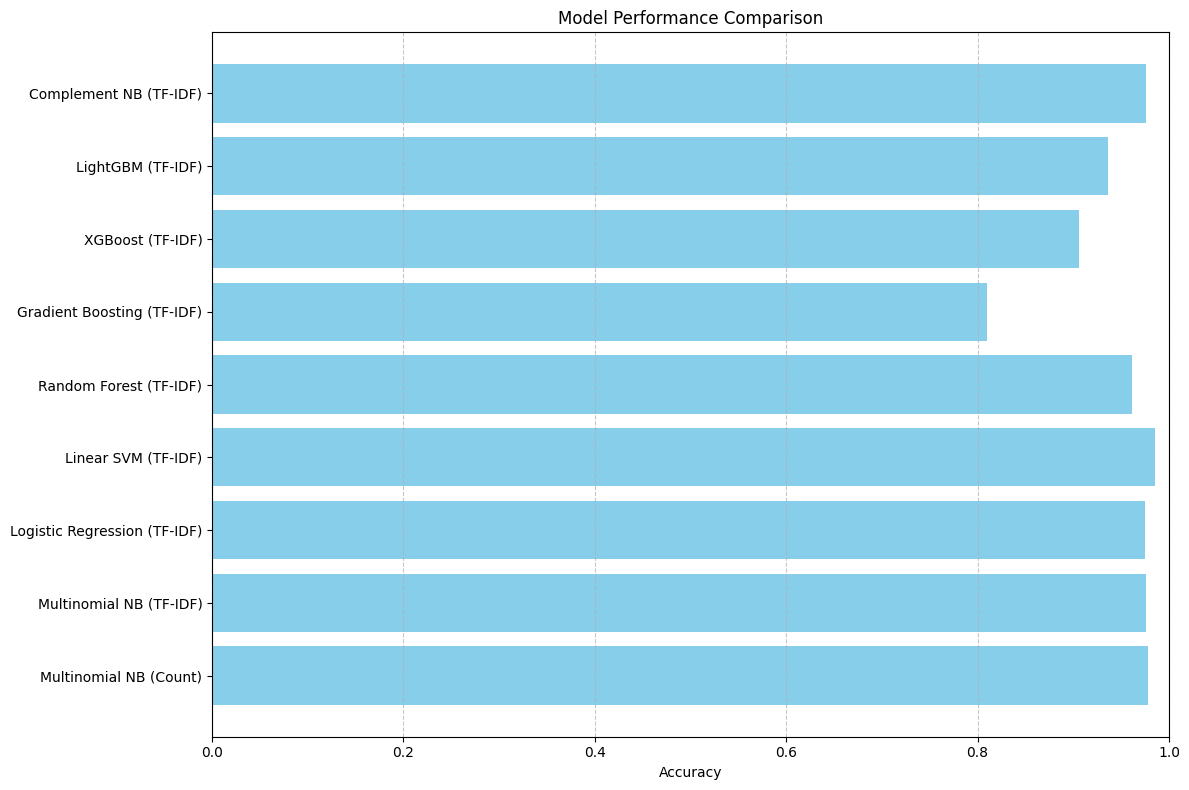

In [11]:
train_file = "clean_train.csv"
test_file = "clean_test.csv"

# Run all models
results = run_all_models(train_file, test_file)
